In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import numpy as np

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=32
epochs=100
num_classes=10
depth=20

In [4]:
model_type = 'MobileNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

# resize
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize

x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize

print(x_train.shape)
print(x_test.shape)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
input_shape=x_train.shape[1:]

4423680/4422102 [==============================] - 0s 0us/step
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [6]:
#datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train, y_train)

In [7]:
# MODEL THAT CLAIMS TO PERFORM BETTER THAN "OVERFITTING MODEL" 

import os
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Dropout, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
# define the filter size
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# define the calculation of each 'inverted Res_Block'
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    prefix = 'block_{}_'.format(block_id)

    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs

    # Expand
    if block_id:
        x = Conv2D(expansion * in_channels, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'expand_BN')(x)
        x = ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False, padding='same', kernel_initializer="he_normal", depthwise_regularizer=regularizers.l2(4e-5), name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'depthwise_BN')(x)
    x = ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)


    if in_channels == pointwise_filters and stride == 1:
        return Add(name=prefix + 'add')([inputs, x])
    return x

#Create Build
def create_model(rows, cols, channels, level_0_blocks, level_1_blocks, level_2_blocks, num_classes, lr_initial):
  # encoder - input
    alpha=1.0
    include_top = True
    model_input = tf.keras.layers.Input(shape=(rows, cols, channels), name='input_image')
    x           = model_input

    first_block_filters = _make_divisible(32 * alpha, 8)

    # model architechture
    x = Conv2D(first_block_filters, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv1')(model_input)

    x = _inverted_res_block(x, filters=16,  alpha=alpha, stride=1, expansion=1, block_id=0 )

    x = _inverted_res_block(x, filters=24,  alpha=alpha, stride=1, expansion=6, block_id=1 )
    x = _inverted_res_block(x, filters=24,  alpha=alpha, stride=1, expansion=6, block_id=2 )

    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=2, expansion=6, block_id=3 )
    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=1, expansion=6, block_id=4 )
    x = _inverted_res_block(x, filters=32,  alpha=alpha, stride=1, expansion=6, block_id=5 )

    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=2, expansion=6, block_id=6 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=7 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=8 )
    x = _inverted_res_block(x, filters=64,  alpha=alpha, stride=1, expansion=6, block_id=9 )
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96,  alpha=alpha, stride=1, expansion=6, block_id=12)
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)
    x = Dropout(rate=0.25)(x)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)
    x = Dropout(rate=0.25)(x)


    # define filter size (last block)
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280


    x = Conv2D(last_block_filters, kernel_size=1, use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv_1')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name='Conv_1_bn')(x)
    x = ReLU(6., name='out_relu')(x)
    
    if include_top:
        x = GlobalAveragePooling2D(name='global_average_pool')(x)
        x = Dense(num_classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # create model of MobileNetV2 (for CIFAR-10)
    model = Model(inputs=model_input, outputs=x, name='mobilenetv2_cifar10')

    #model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = create_model(rows=32, cols=32, channels=1, level_0_blocks=4, level_1_blocks=6, level_2_blocks=3, num_classes=10, lr_initial=0.001)
# reference for model 
# https://github.com/ruchi15/CNN-MobileNetV2-Cifar10/blob/master/CNN_Assignment_5_Design.ipynb

In [8]:
# OVERFITTING MODEL 
'''
def mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=L2(l2=l2_decay),
        input_shape=input_size + (1,))) # change the channel dimension here
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=L2(l2=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.001, N_CLASSES=10)
print(model.summary())
'''

'\ndef mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):\n    """\n    Builds the MobileNet model.\n    :param tuple input_size: The height and width (in that order) of the\n        model input.\n    :param float l2_decay: The amount of L2 weight decay to add to the\n        loss. Applies only to kernels, not biases.\n    :return tensorflow.keras.Sequential: A MobileNet model.\n    """\n\n    model = Sequential()\n\n    def _add_bn_relu():\n        model.add(BatchNormalization(scale=False))\n        model.add(ReLU())\n\n    def _add_depthwise_block(strides=1):\n        model.add(DepthwiseConv2D(\n            (3, 3),\n            strides=strides,\n            padding=\'same\',\n            kernel_regularizer=L2(l2=l2_decay)))\n        _add_bn_relu()\n\n    def _add_pointwise_block(filters):\n        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))\n        _add_bn_relu()\n\n    model.add(Conv2D(\n        32, (3, 3),\n        strides=2,\n        padding=\'

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [10]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_tf.{epoch:03d}.h5'%model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [11]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=2, save_best_only=True)

In [12]:
callbacks = [checkpoint]

In [13]:
batch_size = 32
steps = int(x_train.shape[0]/batch_size)

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=[callbacks], validation_split=0.1)

Epoch 1/100
1688/1688 - 107s - loss: 1.2204 - accuracy: 0.7956 - val_loss: 5.5593 - val_accuracy: 0.1027

Epoch 00001: val_accuracy improved from -inf to 0.10267, saving model to /content/saved_models/cifar10_MobileNet20_model_tf.001.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1688/1688 - 72s - loss: 0.7729 - accuracy: 0.8787 - val_loss: 5.6350 - val_accuracy: 0.1027

Epoch 00002: val_accuracy did not improve from 0.10267
Epoch 3/100
1688/1688 - 72s - loss: 0.6113 - accuracy: 0.8945 - val_loss: 1.1985 - val_accuracy: 0.6568

Epoch 00003: val_accuracy improved from 0.10267 to 0.65683, saving model to /content/saved_models/cifar10_MobileNet20_model_tf.003.h5
Epoch 4/100
1688/1688 - 72s - loss: 0.5355 - accuracy: 0.9001 - val_loss: 0.6443 - val_accuracy: 0.8642

Epoch 00004: val_accuracy improved from 0.65683 to 0.86417, saving model to /content/saved_models/cifar10_MobileNet20_model_tf.004.h5
Epoch 5/100
1688/1688 - 72s - loss: 0.4787 - accuracy: 0.9081 - val_loss: 0.6434 - val_accuracy: 0.8683

Epoch 00005: val_accuracy improved from 0.86417 to 0.86833, saving model to /content/saved_models/cifar10_MobileNet20_model_tf.005.h5
Epoch 6/100
1688/1688 - 72s - loss: 0.4384 - accuracy: 0.9152 - val_loss: 0.4632 - val_accuracy: 0.9003

Epoch 00006: val_a

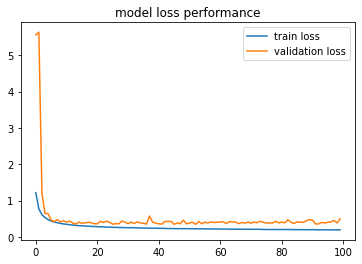

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

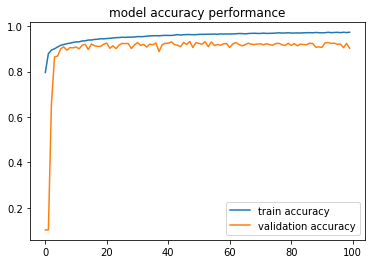

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [17]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 14ms/step - loss: 0.5179 - accuracy: 0.9032


[0.5179480910301208, 0.9031999707221985]

In [ ]:
# https://github.com/mattdutson/mobilenet/blob/master/mobilenet/model.py
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/mobilenet.py
# https://mydeeplearningnb.wordpress.com/2019/07/24/visualizing-cnns-using-tensorflow/